<a href="https://colab.research.google.com/github/nredick/mais202/blob/master/mais_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load dataset from kaggle and unzip the data.
> Upload ~/.kaggle/kaggle.json file before running



In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nathalieredick/rocks-and-fossils
!unzip rocks-and-fossils.zip

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import PIL
import glob
import re
import math
from PIL import Image

In [ ]:
dataset_path = '/content/datasets3 copy'
classes_path = '/content/datasets3 copy/classes.csv'

Load images in color and display some sample images. 

In [ ]:
# read in images
image_paths = list(glob.glob(f'{dataset_path}/X_train/*.jpeg'))
for i in image_paths:
  im = Image.open(i)
  resized = im.resize((32, 32), Image.ANTIALIAS) 
  resized.save(i, 'JPEG', quality=300)
X_train = np.stack([cv2.imread(str(x), cv2.IMREAD_COLOR)
                   for x in image_paths])

image_paths = list(glob.glob(f'{dataset_path}/X_test/*.jpeg'))
for i in image_paths:
  im = Image.open(i)
  resized = im.resize((32, 32), Image.ANTIALIAS) 
  resized.save(i, 'JPEG', quality=300)
X_test = np.stack([cv2.imread(str(x), cv2.IMREAD_COLOR) 
                   for x in image_paths])

(32, 32, 3)


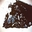

(32, 32, 3)


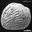

(32, 32, 3)


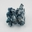

(32, 32, 3)


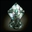

(32, 32, 3)


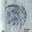

In [ ]:
# display samples 
img_size = X_train[0].shape
for i in range(5):
  print(X_train[i].shape)
  display(PIL.Image.fromarray(X_train[i]))

Remove unwanted noise using Gaussian blur.

In [ ]:
def remove_noise(dataset):
  no_noise = []
  for img in dataset:
      blur = cv2.GaussianBlur(img, (5, 5), 0)
      no_noise.append(blur)
  return no_noise

In [ ]:
X_train_og = X_train
X_train = remove_noise(X_train)
X_test_og = X_test
X_test = remove_noise(X_test)

'Original'

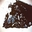

'Blurred'

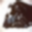

In [ ]:
display('Original', PIL.Image.fromarray(X_train_og[0]), 'Blurred', PIL.Image.fromarray(X_train[0]))

In [ ]:
#get the number of classes 
classes = [re.findall('^[a-z]+', row)[0] for row in open(classes_path, 'r')]
num_classes = sum(1 for c in classes)
print('Classes: ', classes, '\n', 'Number of classes: ', num_classes)

Classes:  ['fossil', 'gemstone', 'mineral', 'rock'] 
 Number of classes:  4


Functions to get labels of data from image file name and convert them to integers

In [ ]:
def get_labels(X):
  y = []
  for item in os.listdir(f'{dataset_path}/{X}/'):
    name = re.findall('^[a-z]+', item)
    y.append(*name)
  return y

y_train = get_labels('X_train')
y_test = get_labels('X_test')
print('y_train: ', y_train, '\ny_test: ', y_test)

y_train:  ['rock', 'fossil', 'mineral', 'gemstone', 'fossil', 'gemstone', 'rock', 'mineral', 'rock', 'fossil', 'mineral', 'rock', 'fossil', 'gemstone', 'rock', 'rock', 'rock', 'fossil', 'fossil', 'fossil', 'gemstone', 'rock', 'rock', 'gemstone', 'mineral', 'gemstone', 'gemstone', 'rock', 'rock', 'fossil', 'mineral', 'fossil', 'fossil', 'rock', 'mineral', 'mineral', 'fossil', 'rock', 'rock', 'gemstone', 'mineral', 'rock', 'gemstone', 'mineral', 'rock', 'rock', 'rock', 'mineral', 'gemstone', 'fossil', 'fossil', 'fossil', 'gemstone', 'mineral', 'mineral', 'gemstone', 'rock', 'mineral', 'rock', 'rock', 'mineral', 'gemstone', 'fossil', 'rock', 'fossil', 'gemstone', 'rock', 'rock', 'gemstone', 'mineral', 'rock', 'mineral', 'mineral', 'rock', 'mineral', 'fossil', 'fossil', 'rock', 'mineral', 'fossil', 'gemstone', 'gemstone', 'mineral', 'fossil', 'rock', 'gemstone', 'mineral', 'fossil', 'mineral', 'gemstone', 'mineral', 'fossil', 'fossil', 'mineral', 'rock', 'fossil', 'fossil', 'mineral', 'min

In [ ]:
def classes_to_nums():
  classes = []
  names = []
  for i, row in enumerate(open(classes_path, 'r')):
    name = re.findall('^[a-z]+', row)
    if name not in names:
      names.append(name)
      classes.append([i, *re.findall('^[a-z]+', row)])
    else:
      print('classes to nums fail')
  return classes

In [ ]:
def numerical_labels(classes, labels):
  result = []
  for l in labels:
    for c in classes:
      if l == c[1]:
        result.append(c[0])
  return result

In [ ]:
# convert image data to numpy arrays 
X_train = np.array(X_train)
X_test = np.array(X_test)

# get encoded labels of each set
numerical_classes = classes_to_nums()
y_train = numerical_labels(numerical_classes, y_train)
y_test = numerical_labels(numerical_classes, y_test)
print(len(y_train))


1801


Instantiate, train, and evaluate the CNN.

In [ ]:
# imports for the CNN
from __future__ import print_function
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential

Using TensorFlow backend.


In [ ]:
# one hot encode data labels for train and test data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(1801, 4)
(259, 4)


In [ ]:
# settings for CNN model
batch_size = 256
epochs = 30
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'rocks_and_fossils.h5'

In [ ]:
# print the data, split between train and test sets:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

num_of_test_samples = X_test.shape[0]

print('X_train shape:', X_train.shape, '\t', X_train.shape[0], 'train samples')
print('X_test shape:', X_test.shape,'\t', X_test.shape[0], 'test samples')

X_train shape: (1801, 32, 32, 3) 	 1801 train samples
X_test shape: (259, 32, 32, 3) 	 259 test samples


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=X_train.shape[1:]))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'mse'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=1, shuffle=True, callbacks=callbacks)

Epoch 1/30
57/57 [==============================] - 4s 68ms/step - loss: 1.2573 - accuracy: 0.4814 - mse: 0.1695 - val_loss: 0.8752 - val_accuracy: 0.6757 - val_mse: 0.1205
Epoch 2/30
57/57 [==============================] - 4s 63ms/step - loss: 1.0119 - accuracy: 0.5997 - mse: 0.1380 - val_loss: 1.0567 - val_accuracy: 0.5676 - val_mse: 0.1478
Epoch 3/30
57/57 [==============================] - 4s 63ms/step - loss: 0.9605 - accuracy: 0.6408 - mse: 0.1293 - val_loss: 0.7561 - val_accuracy: 0.7066 - val_mse: 0.1060
Epoch 4/30
57/57 [==============================] - 4s 63ms/step - loss: 0.8758 - accuracy: 0.6791 - mse: 0.1168 - val_loss: 0.8055 - val_accuracy: 0.6371 - val_mse: 0.1230
Epoch 5/30
57/57 [==============================] - 4s 62ms/step - loss: 0.8814 - accuracy: 0.6952 - mse: 0.1108 - val_loss: 0.7932 - val_accuracy: 0.6448 - val_mse: 0.1125
Epoch 6/30
57/57 [==============================] - 4s 65ms/step - loss: 0.7917 - accuracy: 0.6985 - mse: 0.1069 - val_loss: 0.6348 - v

In [ ]:
# print a summary of the model training 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [ ]:
# save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print(f'Saved trained model at {model_path}')

# score trained model
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# save model as json file
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("model.h5")

Saved trained model at /content/saved_models/rocks_and_fossils.h5
9/9 [==============================] - 0s 13ms/step - loss: 0.1486 - accuracy: 0.9382 - mse: 0.0221
Test loss: 0.14863738417625427
Test accuracy: 0.9382239580154419


Sources:

[Building a CNN (1)](https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5)

[Building a CNN (2)](https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f)

[Early Stopping](https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/)

[Datagen](https://keras.io/examples/cifar10_cnn/)